<a href="https://colab.research.google.com/github/pure-water/utility_ml/blob/master/student_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 This note book is based on FIR2003 dataset and a base model (Resnet and Mobilenet) for class student detection

In [ ]:
from tensorflow import keras
# from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
# Copy Twice, whatever 
! cp /kaggle.json ~/.kaggle/
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! ls ~/


mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat '/content/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download  msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip fer2013

Archive:  fer2013.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/angry/PrivateTest_10304478.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
classes_num = 7
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#YaoGang Colab Setup
Train_DIR = "/content/train"
Test_DIR = "/content/test"


#leagacy setup
##Train_DIR = "../input/fer2013/train"
##Test_DIR = "/content/test"

# one-hot:
def label_img(category):
    arr = np.zeros((classes_num,), dtype = int)
    arr[classes.index(category), ] = 1
    return arr

# Datasets:

img_size = 224
train = []
test = []
def create_train_set(img_size):
    for category in classes:
        imgs = 0
        category_path = os.path.join(Train_DIR, category)
        label = label_img(category)
        for img in os.listdir(category_path):
            imgs = imgs + 1
            if imgs == 4000:
                break
            img_array = cv2.resize(cv2.imread(os.path.join(category_path, img)), (img_size, img_size))
            train.append([np.array(img_array), np.array(label)])

create_train_set(img_size)
train = np.array(train)
test  = np.array(test)
shuffle(train)

print("Train shape",train.shape)
print("Test shape",test.shape)

Train shape (23598, 2)
Test shape (0,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

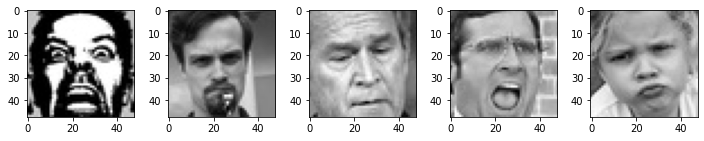

In [ ]:
plot_images('train'+'/angry')


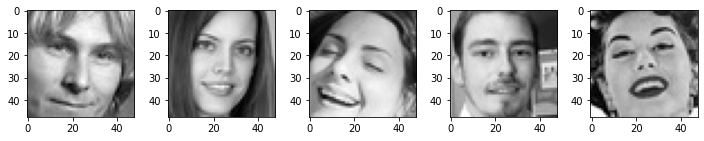

In [ ]:
plot_images('train'+'/happy')

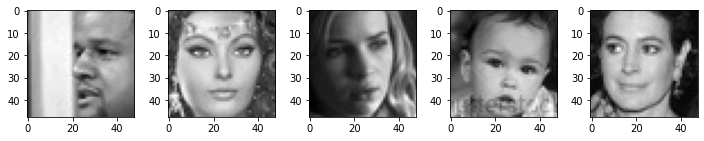

In [ ]:
plot_images('train'+'/neutral')

In [ ]:
# CREATING VALIDATION SET FROM A SUBSET OF TRAINING SET:

# valTOtrain_split_ratio = 0.2  # (val / total)
# num = int(((1 - valTOtrain_split_ratio)*train.shape[0]))
# train_set = train[:num]
# val_set = train[num:]

In [ ]:
import gc
split = 21000
X_train = np.array([i[0] for i in train[:split]]).reshape(-1, img_size, img_size, 3)
y_train = np.array([i[1] for i in train[:split]])

print(X_train.shape)
print(y_train.shape)

X_val = np.array([i[0] for i in train[split:]]).reshape(-1, img_size, img_size, 3)
y_val = np.array([i[1] for i in train[split:]])

print(X_val.shape)
print(y_val.shape)

del train
gc.collect()

(21000, 224, 224, 3)
(21000, 7)
(2598, 224, 224, 3)
(2598, 7)


30691

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras 

In [ ]:
# We shall not build a new model from scratch, rather we will use transfer learning:

img_size = 224
classes_num = 7
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow.keras.applications

resnet_model = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

In [ ]:
for layers in mobilenet_model.layers: 
  layers.trainable = False

In [ ]:
# Model1 using the mobile_net as the base model

model2 = Sequential()
model2.add(mobilenet_model)

model2.add(Flatten())
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(classes_num, activation='softmax'))

model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_14 (Flatten)         (None, 62720)             0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 62720)             250880    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               16056576  
_________________________________________________________________
dense_21 (Dense)             (None, 7)                 1799      
Total params: 18,567,239
Trainable params: 16,183,815
Non-trainable params: 2,383,424
_________________________________________________________________


In [ ]:
checkpoint_path= './'
callback=tf.keras.callbacks.ModelCheckpoint(
     checkpoint_path, verbose=1, save_weights_only=True,
    period=5
)

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])
history2 = model2.fit(X_train, y_train, batch_size = 64, epochs=18, validation_data=(X_val, y_val))

from google.colab import files
model_file = "model_mobilenet_input_224.h5"
model2.save_weights(model_file)
files.download(model_file)

Epoch 1/18
329/329 [==============================] - 696s 2s/step - loss: 0.6116 - accuracy: 0.8320 - val_loss: 3.6818 - val_accuracy: 0.5497
Epoch 2/18
329/329 [==============================] - 699s 2s/step - loss: 0.2373 - accuracy: 0.9525 - val_loss: 4.3916 - val_accuracy: 0.5666
Epoch 3/18
329/329 [==============================] - 696s 2s/step - loss: 0.1094 - accuracy: 0.9782 - val_loss: 4.4753 - val_accuracy: 0.5920
Epoch 4/18
329/329 [==============================] - 702s 2s/step - loss: 0.0615 - accuracy: 0.9920 - val_loss: 5.3025 - val_accuracy: 0.5820
Epoch 5/18
329/329 [==============================] - 698s 2s/step - loss: 0.0829 - accuracy: 0.9850 - val_loss: 5.3233 - val_accuracy: 0.5778
Epoch 6/18
 38/329 [==>...........................] - ETA: 9:16 - loss: 0.0493 - accuracy: 0.9840

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
model_file = "model_mobilenet_input_224.h5"
model2.save_weights(model_file)
files.download(model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model2.save("model_mobilenet_input_224")

In [ ]:
import shutil
shutil.make_archive("model_mobilenet", 'zip', "./model_mobilenet_input_224")

In [ ]:
# Model1 using the resnet_model as the base model and fine tuning it

for layer in resnet_model.layers:
   layer.trainable = False
for layer in resnet_model.layers[-75:]:
   layer.trainable = True

# **IMPORTANT**
# let's visualize layer names and layer indices to see how many layers we should freeze:
# for i, layer in enumerate(resnet_model.layers):
#    print(i, layer.name)

model1 = Sequential()
model1.add(resnet_model)

model1.add(Flatten())
model1.add(BatchNormalization())

model1.add(Dense(classes_num, activation='softmax'))

model1.summary()

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])
history1 = model1.fit(X_train, y_train, batch_size = 64, epochs=25, validation_data=(X_val, y_val))

In [ ]:
model1.save_weights("model_resnet_FineTuned_25ep.h5")

In [ ]:
# import shutil
# shutil.make_archive("model_resnet_FineTuned", 'zip', "./model_resntnet_FineTuned")

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()